In [ ]:
#| default_exp estimation

# Maximum Likelihood estimation

In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from jaxtyping import Float, Array, PRNGKeyArray
from isssm.kalman import kalman
from jax import jit
from scipy.optimize import minimize as minimize_scipy
from isssm.mode_estimation import mode_estimation
from isssm.importance_sampling import normalize_weights
from jax import grad
from jaxopt import BFGS

In [ ]:
#| hide
import jax
from isssm.glssm_models import lcm
from isssm.glssm import simulate_glssm
import tensorflow_probability.substrates.jax.distributions as tfd
import fastcore.test as fct
from isssm.lcssm import nb_lcssm, simulate_lcssm

In [ ]:
#| hide
config = jax.config

config.update("jax_enable_x64", True)

## Gaussian linear models

For Gaussian linear state space models we can evaluate the likelihood analytically with a single pass of the Kalman filter.
Based on the predictions $\hat Y_{t| t - 1}$ and associated covariance matrices $\Psi_{t + 1 | t}$ for $t = 0, \dots n$ produced by the Kalman filter we can derive the gaussian negative log likelihood which is given by the gaussian distribution with that mean and covariance matrix and observation $Y_t$. 

In [ ]:
# | export

vmm = vmap(jnp.matmul, (0, 0))


def gnll(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    x_pred: Float[Array, "n+1 m"],  # predicted states $\hat X_{t+1\bar t}$
    Xi_pred: Float[Array, "n+1 m m"],  # predicted state covariances $\Xi_{t+1\bar t}$
    B: Float[Array, "n+1 p m"],  # state observation matrices $B_{t}$
    Omega: Float[Array, "n+1 p p"],  # observation covariances $\Omega_{t}$
) -> Float:  # gaussian negative log-likelihood
    """Gaussian negative log-likelihood"""
    y_pred = vmm(B, x_pred)
    Psi_pred = vmm(vmm(B, Xi_pred), jnp.transpose(B, (0, 2, 1))) + Omega

    return -tfd.MultivariateNormalFullCovariance(y_pred, Psi_pred).log_prob(y).sum()

In [ ]:
#| hide

x0, A, B, Sigma, Omega = lcm(1, 0., 1., 1., 1.)
_, (y,) = simulate_glssm(x0, A, B, Sigma, Omega, 1, jrn.PRNGKey(34234))

x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)
nll = gnll(y, x_pred, Xi_pred, B, Omega)


EY = jnp.zeros((2,))
CovY = jnp.array([[2., 1.], [1., 3.]])

fct.test_eq(nll, -tfd.MultivariateNormalFullCovariance(EY, CovY).log_prob(y.reshape(-1)))

## MLE in GLSSMs

For a parametrized GLSSM, that is a model that depends on parameters $\theta$, we can use numerical optimization to find the maximum likelihood estimatior.

::: {.callout-caution}
With these methods, the user has to take care that they provide a parametrization that is unconstrained, i.e. using $\log$ transformations for positive parameters.
:::

::: {.callout-note}
## Implementation Detail

For low dimensional state space models obtaining the gradient of the negative log likelihood may be feasible by automatic differentiation, in this case use the `mle_glssm_ad` method. Otherwise the derivative free Nelder-Mead method in `mle_glssm` may be favorable.
:::

In [ ]:
#| export
from scipy.optimize import minimize as minimize_scipy
from jax.scipy.optimize import minimize as minimize_jax
from scipy.optimize import OptimizeResult
from jax.scipy.optimize import OptimizeResults

def mle_glssm(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model,  # parameterize GLSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    options=None, # options for the optimizer
) -> OptimizeResult:  # result of MLE optimization
    """Maximum likelihood estimation for GLSSM"""
    def f(theta: Float[Array, "k"]) -> Float:
        x0, A, B, Sigma, Omega = model(theta, aux)
        _, _, x_pred, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)
        return gnll(y, x_pred, Xi_pred, B, Omega)

    return minimize_scipy(f, theta0, method="Nelder-Mead", options=options)

def mle_glssm_ad(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model,  # parameterize GLSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    options=None, # options for the optimizer
) -> OptimizeResults:  # result of MLE optimization
    """Maximum likelihood estimation for GLSSM using automatic differentiation"""
    
    def f(theta: Float[Array, "k"]) -> Float:
        x0, A, B, Sigma, Omega = model(theta, aux)
        _, _, x_pred, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)
        return gnll(y, x_pred, Xi_pred, B, Omega)

    return minimize_jax(f, theta0, method="BFGS", options=options)

In [ ]:
def parameterized_lcm(theta, aux):
    log_s2_eps, log_s2_eta = theta
    n, x0, s2_x0 = aux

    return lcm(n, x0, s2_x0, jnp.exp(log_s2_eps), jnp.exp(log_s2_eta))
    
theta = jnp.log(jnp.array([2., 3.]))
aux = (100, 0., 1.)
x0, A, B, Sigma, Omega = parameterized_lcm(theta, aux)
_, (y,) = simulate_glssm(x0, A, B, Sigma, Omega, 1, jrn.PRNGKey(15435324))

# start far away from true parameter
result_nelder_mead = mle_glssm(y, parameterized_lcm, 2 * jnp.ones(2), aux, options={"return_all": True})
result_ad = mle_glssm_ad(y, parameterized_lcm, 2 * jnp.ones(2), aux)

In [ ]:
#| hide
#%timeit mle_glssm(y, parameterized_lcm, 2 * jnp.ones(2), aux)
#%timeit mle_glssm_ad(y, parameterized_lcm, 2 * jnp.ones(2), aux)

In [ ]:
import matplotlib.pyplot as plt

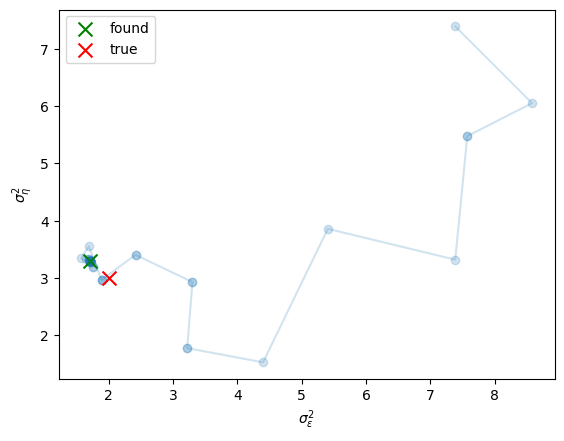

In [ ]:
theta_nm = jnp.array(result_nelder_mead.allvecs)
plt.plot(jnp.exp(theta_nm[:,0]), jnp.exp(theta_nm[:,1]), alpha=.2)
plt.scatter(jnp.exp(theta_nm[:,0]), jnp.exp(theta_nm[:,1]), alpha=.2)
plt.scatter(*jnp.exp(result_ad.x), c="g", marker="x", label="found", s=100)
plt.scatter(*jnp.exp(theta), c="r", s=100, marker="x", label="true")
plt.legend()
plt.xlabel("$\\sigma^2_\\varepsilon$")
plt.ylabel("$\\sigma^2_\\eta$")
plt.show()

## Asymptotic behavior of MLE

::: {.callout-note}
# TODO
Write / Implement
:::

## Inference for Log-Concave State Space Models

For non-gaussian state space models we cannot evaluate the likelihood analytically but resort to simulation methods, more specifically [importance sampling](40_importance_sampling.ipynb). 

Importance Sampling is performed using a surrogate gaussian model that shares the state density $g(x) = p(x)$ and is parameterized by synthetic observations $z$ and their covariance matrices $\Omega$. In this surrogate model the likeilhood $\ell_g = g(z)$ and posterior distribution $g(x|z)$ are tractable and we can [simulate from the posterior](10_kalman_filter_smoother#Sampling_from_the_smoothing_distribution).

Having obtained $N$ independent samples $X^i, i= 1, \dots, N$ from this surrogate posterior we can evaluate the likelihood $\ell$ by Monte-Carlo integration:

$$
\begin{align*}
p(y) &= \int p(x, y) \,\mathrm dx \\
    &=\int \frac{p(x,y)}{g(x|z)} g(x|z) \,\mathrm dx \\
    &= g(z) \int \frac{p(y|x)}{g(z|x)} g(x|z)\,\mathrm dx \\
    &\approx g(z) \frac 1 N \sum_{i =1}^N w(X^i) 
\end{align*}
$$

where $w(X^i) = \frac{p\left(y|X^i\right)}{g\left(z|X^i\right)}$ are the unnormalized importance sampling weights. 

In total we can approximate the negative log-likelihood by

$$
\ell = - \log p(y) \approx \ell_g - \log \left(\sum_{i=1}^N w(X^i) \right) + \log N.
$$


::: {.callout-note}
# TODO
Use differentiation only weights for gradient
::: 

In [ ]:
# |export
from jax.scipy.special import logsumexp
from isssm.importance_sampling import lcssm_importance_sampling
from isssm.kalman import kalman


def _lcnll(
    gnll: Float,  # surrogate gaussian negative log-likelihood
    unnormalized_log_weights: Float[
        Array, "N"
    ],  # unnormalized log-weights $\log w(X^i)$
) -> Float:  # the approximate negative log-likelihood
    """Internal Log-Concave Negative Log-Likelihood"""
    (N,) = unnormalized_log_weights.shape
    return gnll - logsumexp(unnormalized_log_weights) + jnp.log(N)


def lcnll(
    y: Float[Array, "n+1 p"],  # observations
    x0: Float[Array, "m"],  # initial state
    A: Float[Array, "n m m"],  # state transition matrices
    Sigma: Float[Array, "n+1 m m"],  # innovation covariance matrices
    B: Float[Array, "n+1 p m"],  # observation matrices
    xi: Float[Array, "n+1 p"],  # observation parameters
    dist,  # distribution of observations
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # covariance of synthetic observations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> Float:  # the approximate negative log-likelihood
    """Log-Concave Negative Log-Likelihood"""

    key, subkey = jrn.split(key)

    _, log_weights = lcssm_importance_sampling(
        y, x0, A, Sigma, B, xi, dist, z, Omega, N, subkey
    )

    _, _, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)

    return _lcnll(gnll(z, x_pred, Xi_pred, B, Omega), log_weights)

In [ ]:
#| hide
fct.test_close(_lcnll(0., jnp.array([0., 0.])), 0.)

To perform maximum likelihood estimation in a parameterized log-concave state space model we have to evaluate the likelihood several times. For evaluating the likelihood at $\theta$ we have to perform the following:

1. Find a surrogate gaussian model $g(x,z)$ for $p_\theta(x,y)$ (e.g. [mode estimation](30_mode_estimation.ipynb) or [efficient importance sampling](50_modified_efficient_importance_sampling.ipynb)).
2. Generate [importance samples](40_importance_sampling.ipynb) from these models using the [Kalman smoother](10_kalman_filter_smoother.ipynb).
3. Approximate the negative log likelihood using the methods of this module.

This makes maximum likelihood an intensive task for these kinds of models.

For an initial guess we optimize the approximatie loglikelihood with the weights component fixed at the mode, see Eq. (21) in[@Duribn1997Monte] for further details. 

In [ ]:
#| export
from isssm.importance_sampling import log_weights

def initial_theta(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model,  # parameterized LCSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    n_iter_me: int, # number of mode estimation iterations
    s_init: Float[Array, "n+1 m"],  # initial signals for mode estimation
    options=None, # options for the optimizer
):
    """Initial value for Maximum Likelihood Estimation for Log Concave SSMs"""
    def f(theta):
        x0, A, Sigma, B, dist, xi = model(theta, aux)
        
        X, z, Omega = mode_estimation(y, x0, A, Sigma, B, dist, xi, s_init, n_iter_me)

        signal = (B @ X[:,:,None])[:,:,0]
        _, _, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)

        negloglik = gnll(z, x_pred, Xi_pred, B, Omega) - log_weights(signal, y, dist, xi, z, Omega).sum()
        return negloglik
    
    # Nelder-Mead does not use gradients
    result = minimize_scipy(f, theta0, method="BFGS", options=options)
    #solver = BFGS(f, value_and_grad=True, )
    #result = solver.run(theta0)
    return result 

In [ ]:
#| export
def mle_lcssm(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model,  # parameterized LCSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    n_iter_me: int, # number of mode estimation iterations
    s_init: Float[Array, "n+1 m"],  # initial signals for mode estimation
    N: int, # number of importance samples
    key: Array, # random key
    options=None, # options for the optimizer
) -> Float[Array, "k"]: # MLE
    """Maximum Likelihood Estimation for Log Concave SSMs"""

    key, subkey = jrn.split(key)
    def model_log_prob(theta, X):
        x0, A, Sigma, B, dist, xi = model(theta, aux)
        n, _, _ = A.shape

        signal = (B @ X[:,:,None])[:,:,0]
        return dist(signal, xi).log_prob(y).sum()

    d_model_log_prob = grad(model_log_prob, argnums=0)
    vd_model_log_prob = vmap(d_model_log_prob, (None, 0))

    def f(theta):
        x0, A, Sigma, B, dist, xi = model(theta, aux)
        
        _, z, Omega = mode_estimation(y, x0, A, Sigma, B, dist, xi, s_init, n_iter_me)

        samples, log_weights = lcssm_importance_sampling(
            y, x0, A, Sigma, B, dist, xi, z, Omega, N, subkey
        )

        _, _, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)

        negloglik = _lcnll(gnll(z, x_pred, Xi_pred, B, Omega), log_weights)
        norm_weights = normalize_weights(log_weights)
        gradient = -(vd_model_log_prob(theta, samples) * norm_weights[:, None]).sum(axis=0)
        return negloglik, gradient
    
    # Nelder-Mead does not use gradients
    result = minimize_scipy(f, theta0, method="BFGS", options=options, jac=True)
    #solver = BFGS(f, value_and_grad=True, )
    #result = solver.run(theta0)
    return result 

As an example consider a parameterized version of the [common factor negative binomial model](20_lcssm.ipynb#Negative_Binomial_Common_Factor_Model) with unknown parameters $\sigma^2_\varepsilon$ and $r$.

In [ ]:

def lc_model(theta, aux):
    log_s2_eps, log_r = theta

    n, x0 = aux
    
    r = jnp.exp(log_r)
    s2_eps = jnp.exp(log_s2_eps)

    A = jnp.broadcast_to(jnp.eye(3), (n, 3, 3))
    Sigma = jnp.broadcast_to(jnp.eye(3) * s2_eps, (n+1, 3, 3))
    B = jnp.broadcast_to(jnp.array([[1., 1., 0.], [0., 1., 1.]]), (n+1, 2, 3))

    return nb_lcssm(x0, A, Sigma, B, r)

n = 10
theta_lc = jnp.array([jnp.log(0.1), jnp.log(20.)])
aux = (n, jnp.ones(3))
x0, A, Sigma, B, dist, xi = lc_model(theta_lc, aux)
key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
_, (y,) = simulate_lcssm(x0, A, Sigma, B, dist, xi, 1, subkey)

In [ ]:
initial_result = initial_theta(
    y, lc_model, theta_lc, aux, 10, jnp.log(y + 1) 
)
theta0 = initial_result.x
theta0

array([-2.16919616,  0.68065415])

In [ ]:
#| hide
# start at true parameter
key, subkey = jrn.split(key)
result = mle_lcssm(y, lc_model, theta0, aux, 10, jnp.log(y + 1.), 1000, subkey)

In [ ]:
#| hide
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 44.67525341898696
        x: [-2.169e+00  6.815e-01]
      nit: 1
      jac: [-0.000e+00  7.149e-04]
 hess_inv: [[ 1.000e+00  0.000e+00]
            [ 0.000e+00  5.368e-01]]
     nfev: 29
     njev: 17

In [ ]:
@jit
def lcnll_full(theta):
    x0, A, Sigma, B, xi_fun, dist = lc_model(theta, aux)

    _, z, Omega = mode_estimation(y, x0, A, Sigma, B, xi_fun, dist, jnp.log(y + 1.), 10)

    return lcnll(y, x0, A, Sigma, B, xi_fun, dist, z, Omega, 1000, subkey)

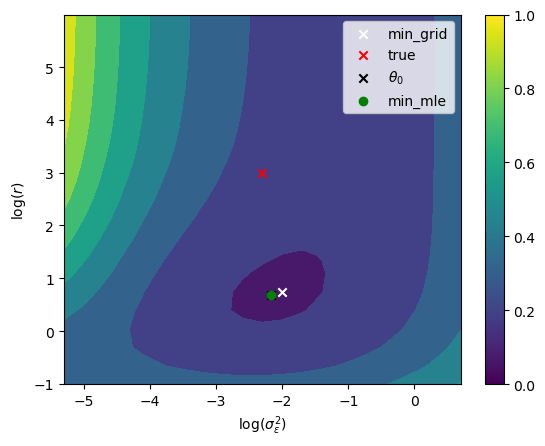

In [ ]:
# 2d grid on the log scale
log_sigma, log_r = jnp.meshgrid(jnp.linspace(-3, 3, 21) + theta_lc[0], jnp.linspace(-4, 3, 21) + theta_lc[1])
#flatten
thetas = jnp.vstack([log_sigma.ravel(), log_r.ravel()]).T

nlls = vmap(lcnll_full)(thetas)
#location of minium in nlls
i = jnp.argmin(nlls)
#location of minimum in the grid
i_sigma, i_r = i // 21, i % 21

plt.contourf(log_sigma, log_r, nlls.reshape(21, 21))
plt.scatter(log_sigma[i_sigma, i_r], log_r[i_sigma, i_r], c="white", marker="x", label="min_grid")
plt.scatter(theta_lc[0], theta_lc[1], c="r", marker="x", label="true")
plt.scatter(theta0[0], theta0[1], c="black", marker="x", label="$\\theta_0$")
plt.scatter(*result.x, c="g", marker="o", label="min_mle")
plt.legend()
plt.xlabel("$\\log(\\sigma^2_\\varepsilon)$")
plt.ylabel("$\\log(r)$")
plt.colorbar()
plt.show()

In [ ]:
theta0

array([-2.16919616,  0.68065415])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()